## Y1 spetroscopic systematic consistent check

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles

In [2]:
import fitsio
from astropy.table import Table
from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask
from Y3_redshift_systematics import vsmear, vsmear_modelling

c = 299792 # speed of light in km/s

def Y3_obs_vsmear_modeling(tracer,zmin,zmax, bins= None, dvfn='./'):
    # Validate the tracer input
    if tracer[:3] in ['LRG', 'ELG', 'QSO']:
        repeatdir= '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs.fits'
        mask, mask_key = desi_mask, "DESI_TARGET"
        effkey, effmin, effmax, effxlim = (
            "TSNR2_LRG",
            0.85 * 1000,
            1.5 * 1000,
            (500, 1500),
        )
    elif tracer[:3] == 'BGS':
        repeatdir= '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-bright-pairs.fits'
        mask, mask_key = bgs_mask, "BGS_TARGET"
        effkey, effmin, effmax, effxlim = "TSNR2_BGS", 0.85 * 180, 1.5 * 180, (0, 500)
    else:
        raise ValueError(f"Invalid tracer: {tracer[:3]}. Must be in/be a subsample of ['BGS', 'LRG', 'ELG', 'QSO'].")
    # Create the output directory if not existed
    if not os.path.exists(dvfn):
        os.system(f'mkdir -p {dvfn}')

    # Read the observed pairs 
    d     = Table.read(repeatdir)

    # Set parameters for the selection and calculation process
    catasmin, catasmax, catasbin = -3, 6, 0.2
    goodkey = f"GOOD_{tracer[:3]}"
    if tracer == "QSO":
        catasmin = -2
    
    # Redrock redshift selections:
    if tracer != 'QSO':
        # efftime_spec calculation for selections
        snr2time = d.meta["{}SNR2T".format(effkey.split("_")[1])]
        efftime0s = snr2time * d["{}_0".format(effkey)]
        efftime1s = snr2time * d["{}_1".format(effkey)]
        # zmtl_zwarn_mask nodata + bad selections
        nodata0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask["NODATA"]) > 0
        nodata1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask["NODATA"]) > 0
        badqa0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0
        badqa1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0
        # Apply the selection criteria to clean the data
        sel = (d[mask_key] & mask[tracer]) > 0
        sel &= (d["COADD_FIBERSTATUS_0"] == 0) & (d["COADD_FIBERSTATUS_1"] == 0)
        sel &= (~nodata0) & (~nodata1)
        sel &= (~badqa0) & (~badqa1)
        sel &= (efftime0s > effmin) & (efftime1s > effmin)
        sel &= (efftime0s < effmax) & (efftime1s < effmax)
        sel &= (d["{}_0".format(goodkey)]) & (d["{}_1".format(goodkey)])
        sel &= (d['SURVEY_0']=='main')&(d['SURVEY_1']=='main')
        if tracer[:3] == 'ELG':
            sel &= (~d["GOOD_QSO_0"]) & (~d["GOOD_QSO_1"])
    else:
        qsofn    = repeatdir[:-5]+'_QSO'+repeatdir[-5:]
        d        = Table(fitsio.read(qsofn))
        d        = d[~np.isnan(d['DV'])]
        sel      = np.full(len(d),True)
        
    # cut on redshift range 
    selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
    dv_final = np.log10(abs(d['DV'][sel&selz]))  
    
    # provide the Delta_velocity distributions
    dens,bins = np.histogram(dv_final,bins=bins,density=True)
    return dens, bins[:-1]

def Y1_obs_vsmear_modeling(tracer, zmin, zmax, bins= None, dvfn='./'):
    # Validate the tracer input
    if tracer[:3] in ['LRG', 'ELG', 'QSO']:
        repeatdir= '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y1/ELG_LOPnotqso_sv3-iron_main-iron_nozsel_ZWARN04.fits'
        mask, mask_key = desi_mask, "DESI_TARGET"
        effkey, effmin, effmax, effxlim = (
            "TSNR2_LRG",
            0.85 * 1000,
            1.5 * 1000,
            (500, 1500),
        )
    elif tracer[:3] == 'BGS':
        repeatdir= '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-bright-pairs.fits'
        mask, mask_key = bgs_mask, "BGS_TARGET"
        effkey, effmin, effmax, effxlim = "TSNR2_BGS", 0.85 * 180, 1.5 * 180, (0, 500)
    else:
        raise ValueError(f"Invalid tracer: {tracer[:3]}. Must be in/be a subsample of ['BGS', 'LRG', 'ELG', 'QSO'].")
    # Create the output directory if not existed
    if not os.path.exists(dvfn):
        os.system(f'mkdir -p {dvfn}')

    # Read the observed pairs 
    d     = Table.read(repeatdir)

    # Set parameters for the selection and calculation process
    catasmin, catasmax, catasbin = -3, 6, 0.2
    goodkey = f"GOOD_{tracer[:3]}"
    if tracer == "QSO":
        catasmin = -2
        
    # cut on redshift range 
    selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
    dv_final = np.log10(abs(d['DV'][selz])) 

    # provide the Delta_velocity distributions
    # dens,bins = np.histogram(dv_final,bins=np.arange(catasmin,catasmax,catasbin),density=True)
    dens,bins = np.histogram(dv_final,bins=bins,density=True)
    return dens, bins[:-1]

def plot_bins(data, bins=None):
    n, bin_edges = np.histogram(data, bins=bins, density= True)
    return(n, bin_edges[:-1])


Z_realistic ratio: 0.0026951174091680912
Z_failures ratio: 0.009985351347705338


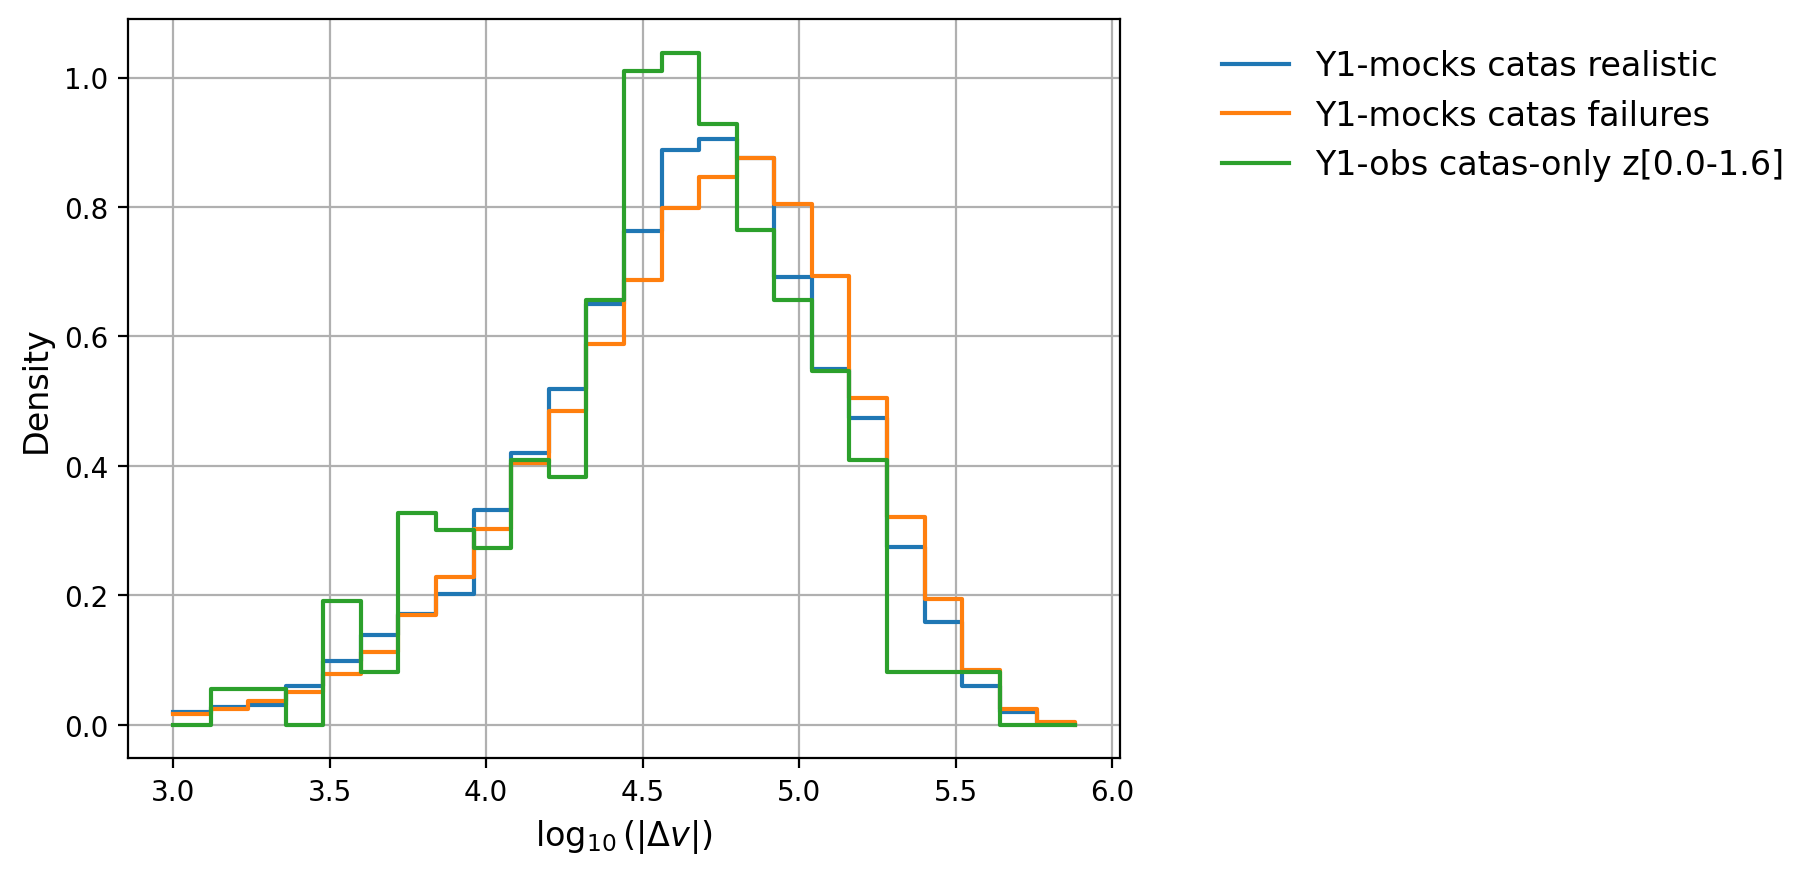

In [3]:
# consistent check with Y1 mocks and Y1 inverse-sampling
zmin = 0.0
zmax = 1.6
bins = np.linspace(3,6,26)

mock_id = 0
Y1_ctm_mocks_name = f'/pscratch/sd/j/jiaxi/Y1/AbacusSummit_v4_1/altmtl{mock_id}/mock{mock_id}/LSScats/ELG_LOPnotqso_clustering.dat.fits'
with fits.open(Y1_ctm_mocks_name, memmap=True) as hdul:
    dat_mocks = hdul[1].data

dv_labels = ['Y1-mocks catas realistic', 'Y1-mocks catas failures']
for i,zcatas_fn in enumerate(['Z_realistic', 'Z_failures']):
    z_diff = dat_mocks['Z'][(dat_mocks['Z']>zmin)&(dat_mocks['Z']<zmax)]-dat_mocks[zcatas_fn][(dat_mocks['Z']>zmin)&(dat_mocks['Z']<zmax)]
    print(f'{zcatas_fn} ratio:',len(z_diff[np.nonzero(z_diff)])/len(z_diff))
    delta_z = z_diff[np.nonzero(z_diff)]
    delta_v = abs(delta_z*c/(1+dat_mocks['Z'][np.nonzero(z_diff)]))
    log_delta_v = np.log10(delta_v)
    (y, x) = plot_bins(log_delta_v, bins=bins)
    plt.plot(x, y, drawstyle='steps-post',label=dv_labels[i])
    
dens_obs_Y1,_ = Y1_obs_vsmear_modeling('ELG', zmin=zmin, zmax=zmax, bins=bins)
plt.plot(x, dens_obs_Y1, drawstyle='steps-post', label=f'Y1-obs catas-only z[{0.0}-{1.6}]', color='C2')

bbox_to_anchor = (1.7, 1)
plt.legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
plt.ylabel(r'Density')
# plt.ylim([-0.1, 1.5])
plt.grid(True)
plt.xlabel(r'$\log_{10}(|\Delta v|)$')
plt.show()

# redshift evolution catastrophic --> redshift bins

load /global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/ELG_z0.0-1.6_CDF.npz to add redshift uncertainties and catastrophics
Y3 vsmear catasonly ratio 0.0025814767131884793


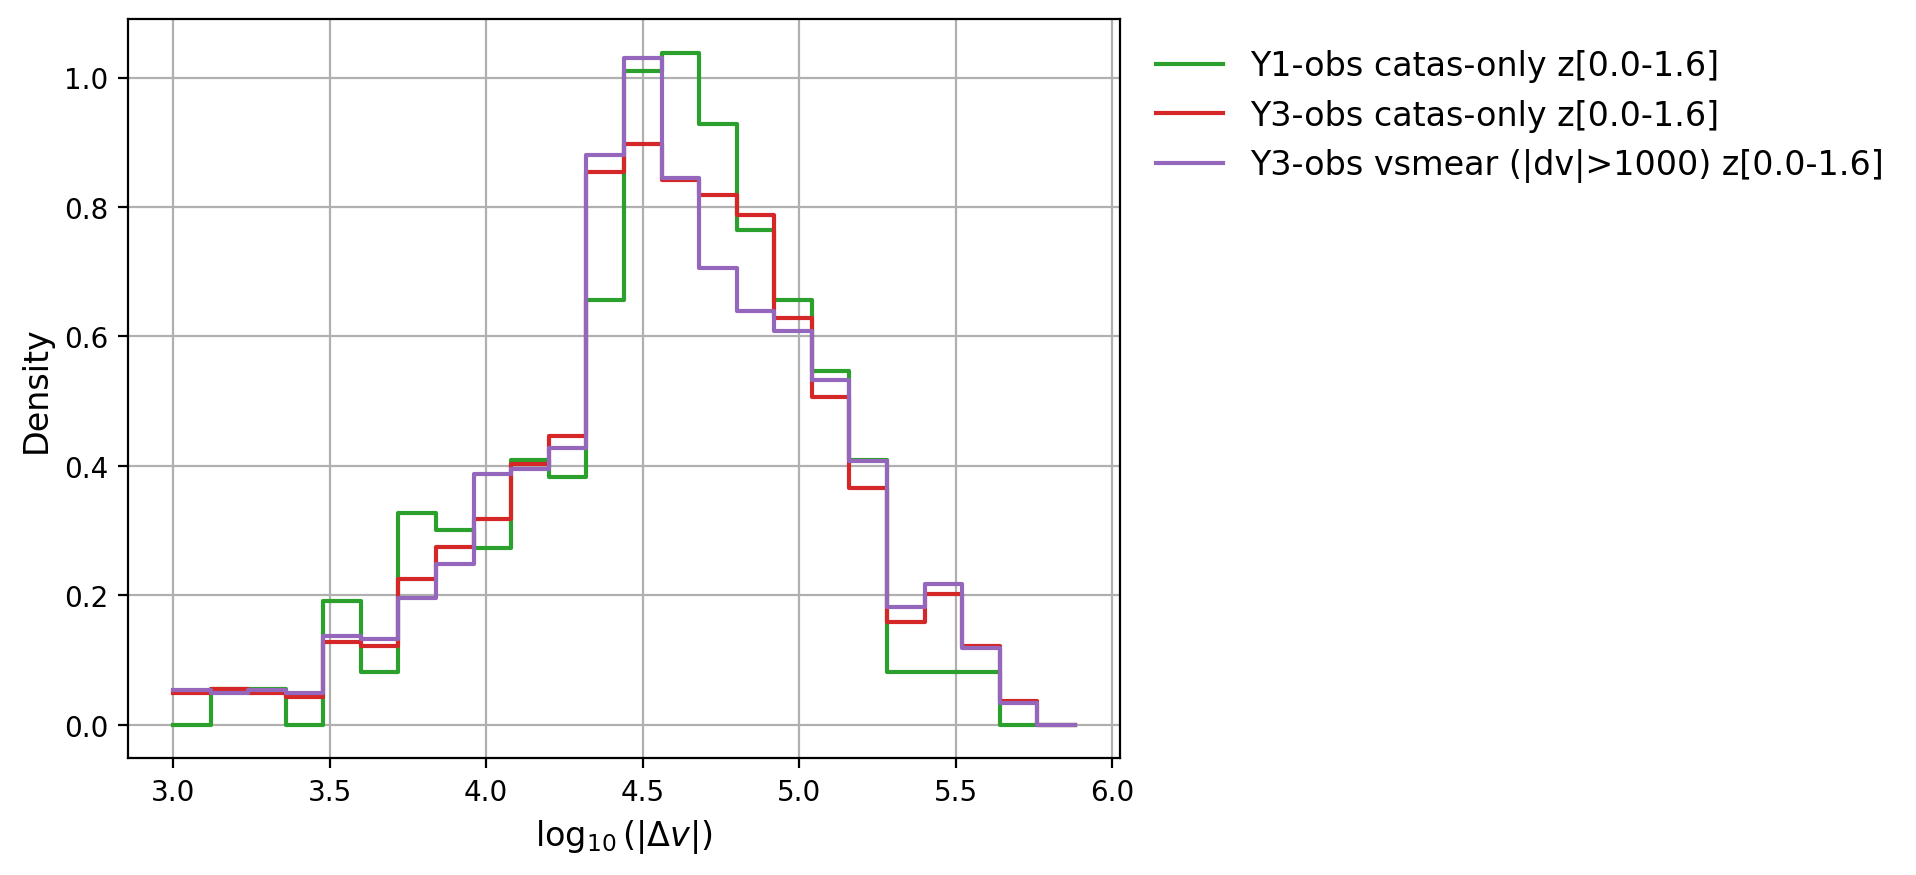

In [4]:
# consistent check with vsmear (all sys) script and vsmear-modeling (catasonly) script
zmin = 0.0
zmax = 1.6
bins = np.linspace(3,6,26)

dens_obs_Y1, _ = Y1_obs_vsmear_modeling('ELG', zmin=zmin, zmax=zmax, bins=bins)
plt.plot(x, dens_obs_Y1, drawstyle='steps-post', label=f'Y1-obs catas-only z[{0.0}-{1.6}]', color='C2')

dens_obs_Y3, _ = Y3_obs_vsmear_modeling('ELG', zmin=zmin, zmax=zmax, bins=bins)
plt.plot(x, dens_obs_Y3, drawstyle='steps-post', label=f'Y3-obs catas-only z[{0.0}-{1.6}]', color='C3')

dv = vsmear('ELG', zmin=zmin, zmax=zmax, Ngal = len(z_diff))
print('Y3 vsmear catasonly ratio', len(dv[np.abs(dv)>1000])/len(dv))
(y, x) = plot_bins(np.log10(abs(dv[abs(dv)>1000])), bins=bins)
plt.plot(x, y, drawstyle='steps-post',label=f'Y3-obs vsmear (|dv|>1000) z[{0.0}-{1.6}]', color='C4')

bbox_to_anchor = (1.8, 1)
plt.legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
plt.ylabel(r'Density')
# plt.ylim([-0.1, 1.5])
plt.grid(True)
plt.xlabel(r'$\log_{10}(|\Delta v|)$')
plt.show()

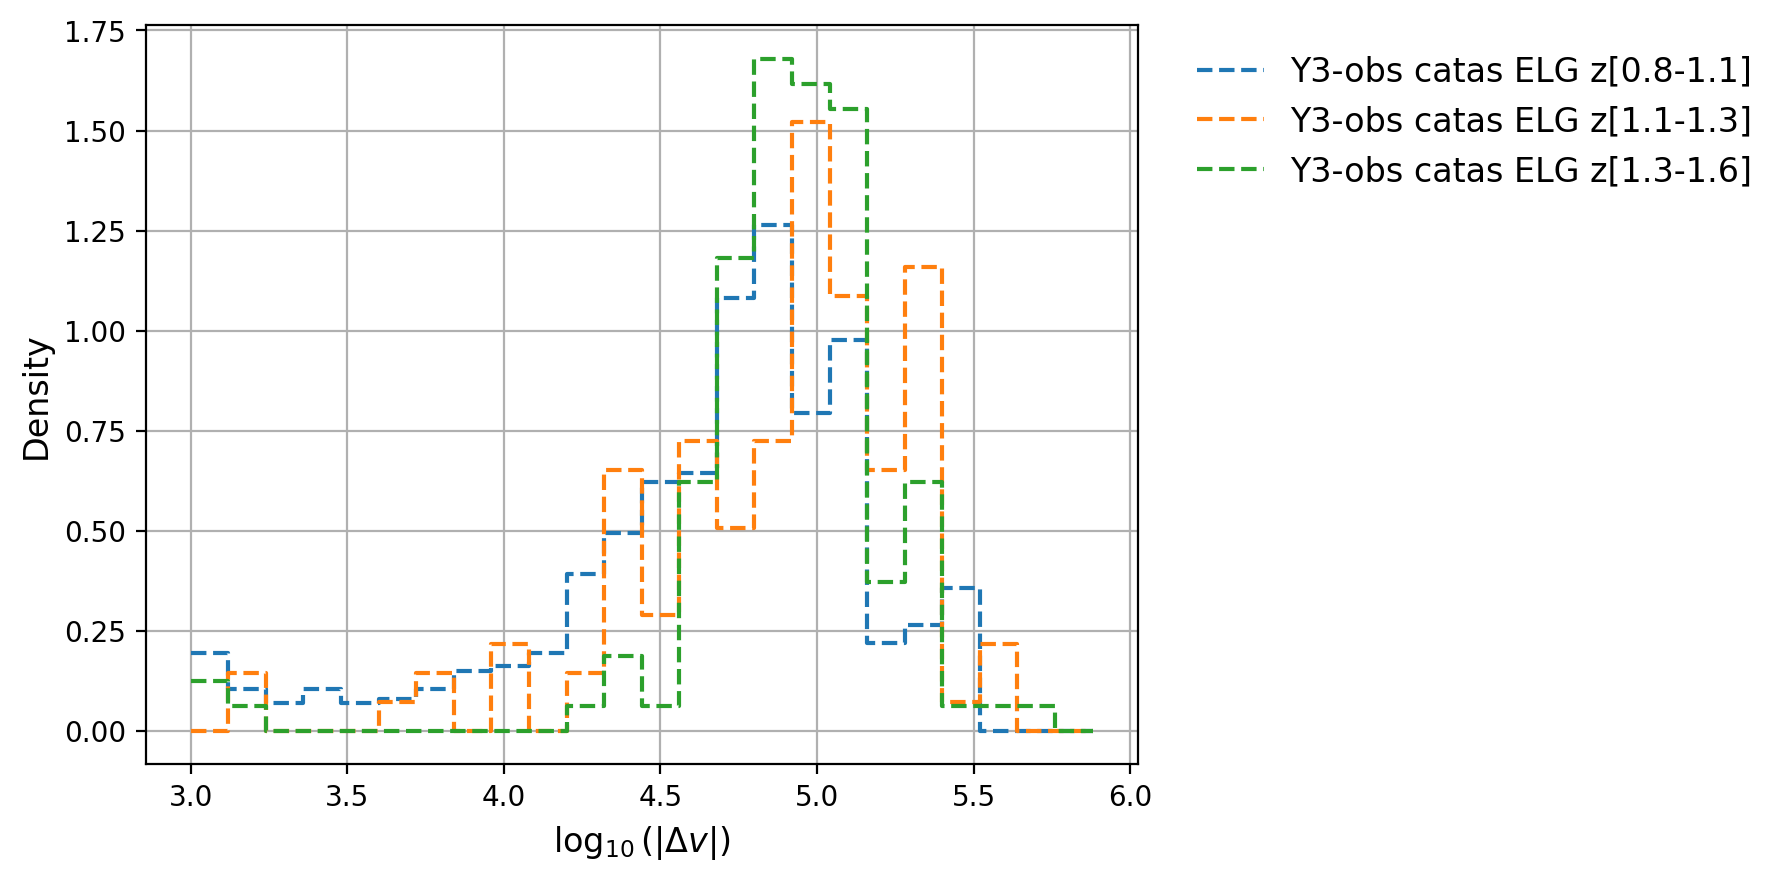

In [8]:
# check with redshift evolution of redshift catastrophics
bins = np.linspace(3,6,26)

colors = ['C0', 'C1', 'C2']
lss = ['--', '--', '--']
zbins = [(0.8, 1.1),(1.1,1.3),(1.3,1.6)]
for i,(zmin, zmax) in enumerate(zbins):
    dens_obs_Y3, x = Y3_obs_vsmear_modeling('LRG', zmin=zmin, zmax=zmax, bins=bins)
    plt.plot(x, dens_obs_Y3, drawstyle='steps-post', label=f'Y3-obs catas ELG z[{zmin}-{zmax}]', color=colors[i], ls = lss[i])

bbox_to_anchor = (1.65, 1)
plt.legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
plt.ylabel(r'Density')
# plt.ylim([-0.1, 1.5])
plt.grid(True)
plt.xlabel(r'$\log_{10}(|\Delta v|)$')
plt.show()

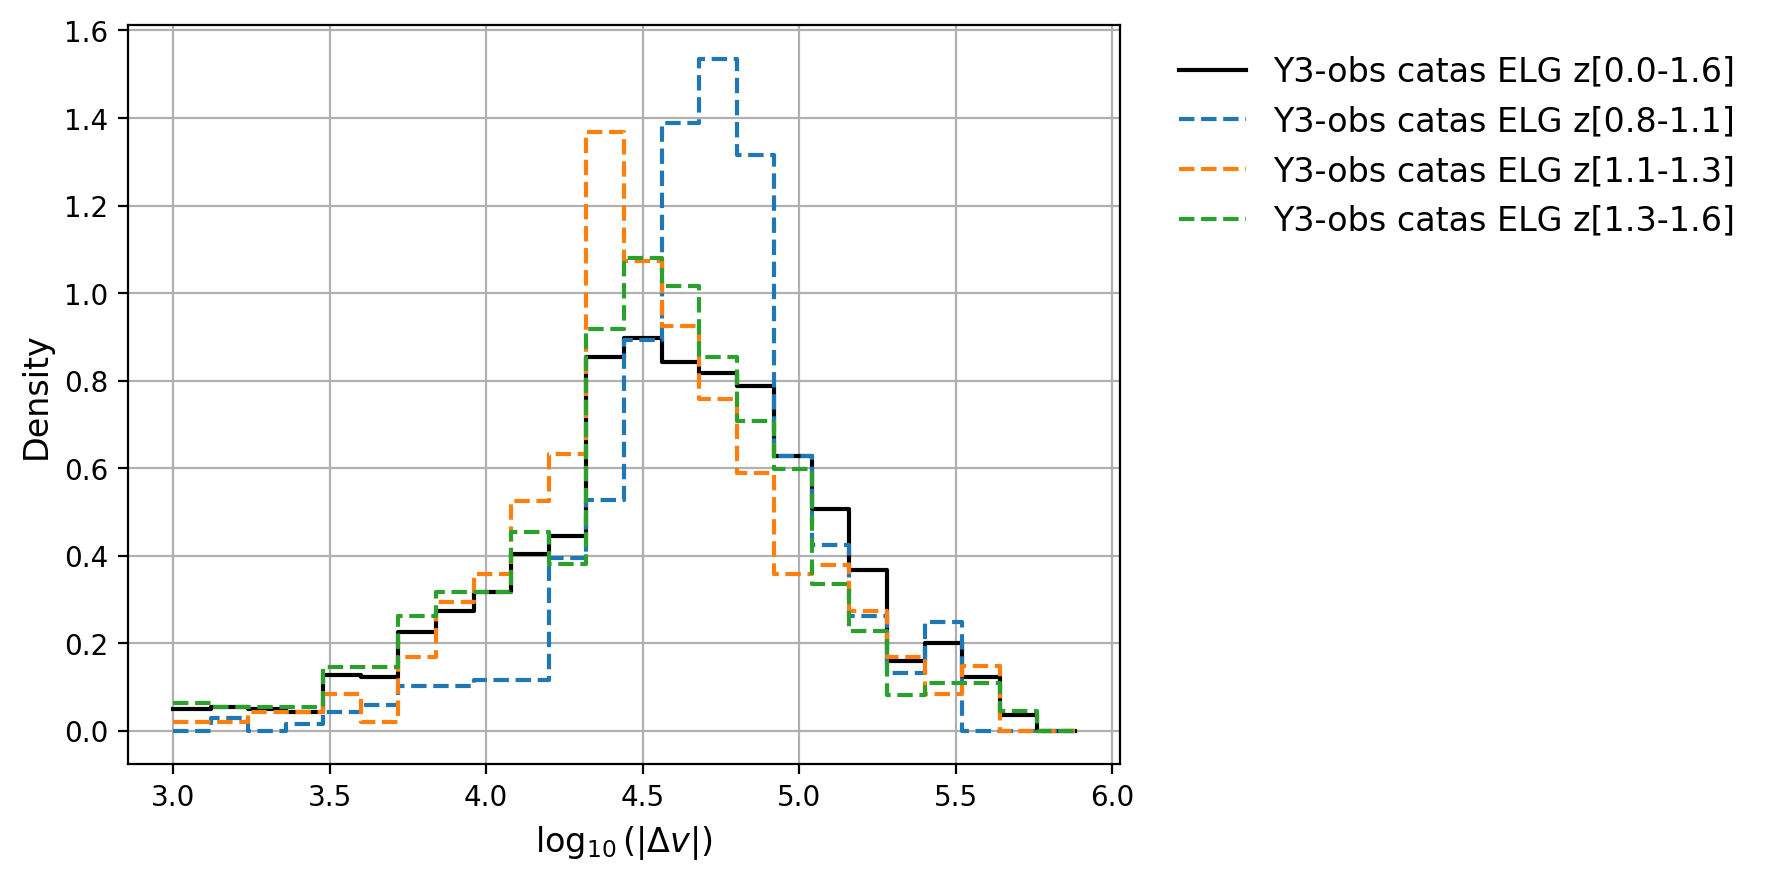

In [10]:
# check with redshift evolution of redshift catastrophics
bins = np.linspace(3,6,26)

colors = ['black', 'C0', 'C1', 'C2']
lss = ['-', '--', '--', '--']
for i,(zmin, zmax) in enumerate([(0.0,1.6),(0.8, 1.1),(1.1,1.3),(1.3,1.6)]):
    dens_obs_Y3, x = Y3_obs_vsmear_modeling('ELG', zmin=zmin, zmax=zmax, bins=bins)
    plt.plot(x, dens_obs_Y3, drawstyle='steps-post', label=f'Y3-obs catas ELG z[{zmin}-{zmax}]', color=colors[i], ls = lss[i])

bbox_to_anchor = (1.65, 1)
plt.legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
plt.ylabel(r'Density')
# plt.ylim([-0.1, 1.5])
plt.grid(True)
plt.xlabel(r'$\log_{10}(|\Delta v|)$')
plt.show()